In [151]:
import sys
import os
import cairosvg
from IPython.core.display import display, Markdown
from PIL import Image
from json_dict import JsonDict
sys.path.append(os.path.abspath(".."))
import main
import pandas as pd
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
import pickle
import json
os.chdir(os.path.dirname(main.__file__))

In [329]:
FORCE_NEW=False
SHOW_IMAGES=False
SEED=1995
DPI=300
#EVALUATION_PARAMETER
c_min=0
c_max=30
deg_min=10
deg_max=300

pixel=100*100

true_name="z_average"
predicted_name="predicted_z_average"
metric_steps=["training","validation"]
metric_epoch_limit=2000
metric_highlighted_epochs=[10,50,99,500]

display_quantiles = [1.,0.99,0.95,0.90]

random_comparison_true_pred_number=40

In [330]:
#PRECALCULAIONS
pixerl_1d=np.sqrt(pixel)
c_delt=(c_max-c_min)/pixerl_1d
deg_delt=(deg_max-deg_min)/(pixerl_1d-1)

c_delt =(c_max-c_min)/(pixerl_1d-1)

concentrations = np.arange(0,30,0.1)
poly_deg = np.arange(deg_min,deg_max+deg_delt,deg_delt)
concentrations = np.arange(c_min,c_max+c_delt,c_delt)

In [358]:
%matplotlib inline

#FUNCTIONS
def load_config(model_path):
    if not os.path.exists(os.path.join(model_path,"config.json")):
        raise FileNotFoundError("Model config '{}' not found".format(os.path.join(model_path,"config.json")))
    return JsonDict(os.path.join(model_path,"config.json"))

def load_model(config):
    model = main.load_model(config.getsubdict("model"))
    return model

def load_data(config):
    training_history=config.get("training","training_history",default=[])
    if len(training_history)<1:
        raise ValueError("model '{}' has no training history".format(config.get("model","name")))
    training_data = training_history[-1]['args']['train']
    if not os.path.exists(training_data):
        raise FileNotFoundError("Training data '{}' not found".format(training_data))

    train_df = pd.read_csv(training_data)

    test_data = training_data.replace("train_data_size_kept","train_data_size_removed")
    if not os.path.exists(test_data):
            raise FileNotFoundError("Training data '{}' not found".format(test_data))
    test_df = pd.read_csv(test_data)
    return train_df,test_df

def data_prediction(model,train_df,test_df,eval_dir):
    print("data_prediction")
    def _pred(df):
        if np.any(np.isnan(df["dp"])):
            raise ValueError("DP is None in for data with '{}'".format(model.name) )
        df =  main.predict(model,df)
        df["error"] = np.abs(df[predicted_name]-df[true_name])
        df["rel_error"] = df["error"]/df[true_name]
        return df

    new=False
    n_train_df=None
    if os.path.exists(os.path.join(eval_dir,"train_df.csv")):
        n_train_df = pd.read_csv(os.path.join(eval_dir,"train_df.csv"))

    if n_train_df is None or n_train_df.shape[0] != train_df.shape[0] or \
                not n_train_df[['circular_smiles_10']].equals(train_df[['circular_smiles_10']]) or \
                not np.allclose(n_train_df[['dp','polymer_concentration',"pdi","with_pva","z_average"]].values,
                                                train_df[['dp','polymer_concentration',"pdi","with_pva","z_average"]].values
                                            ) or \
                 not np.allclose(main.predict(model,train_df.iloc[[0]],verbose=False)[predicted_name].values,
                                 n_train_df.iloc[[0]][predicted_name].values
                                 ):
        n_train_df= _pred(train_df)
        n_train_df.to_csv(os.path.join(eval_dir,"train_df.csv"),index=None)
        new=True

    n_test_df=None
    if os.path.exists(os.path.join(eval_dir,"test_df.csv")):
        n_test_df = pd.read_csv(os.path.join(eval_dir,"test_df.csv"))

    if n_test_df is None or n_test_df.shape[0] != test_df.shape[0] or \
                not n_test_df[['circular_smiles_10']].equals(test_df[['circular_smiles_10']]) or \
                not np.allclose(n_test_df[['dp','polymer_concentration',"pdi","with_pva","z_average"]].values,
                                                test_df[['dp','polymer_concentration',"pdi","with_pva","z_average"]].values
                                            ) or \
            not np.allclose(main.predict(model,test_df.iloc[[0]],verbose=False)[predicted_name].values,
                            n_test_df.iloc[[0]][predicted_name].values
                            ):
        n_test_df= _pred(test_df)
        n_test_df.to_csv(os.path.join(eval_dir,"test_df.csv"),index=None)
        new=True

    return n_train_df,n_test_df,new

def display_metrics(model,eval_dir):
    print("display_metrics")
    td = pickle.load(open(os.path.join(model.get_dir(),"training","training_metrics.mtr"), "rb"))
    steps=[]
    epochs=[]
    metrics=[]
    for step, data in td.items():
        if step == "epochs":
            continue
        steps.append(step)
        for epoch, dmetrics in data.items():
            if epoch not in epochs:
                epochs.append(epoch)
            for metric,mdata in dmetrics.items():
                if metric not in metrics:
                    metrics.append(metric)
    epochs=np.sort(epochs)
    steps=[s for s in steps if s in metric_steps]

    data=np.zeros((len(steps),len(metrics),len(epochs)))*np.nan
    for i,step in enumerate(steps):
                for j,metric in enumerate(metrics):
                    for k,epoch in enumerate(epochs):
                        try:
                            data[i,j,k] = td[step][epoch][metric]
                        except KeyError as ke:
                            raise ke


    def _disp(from_epoch,to_epoch,name,highlights=[]):
        b=iter(["-","--",'-.',':'])
        plt.figure(dpi=300,figsize=(12,3))

        for i,step in enumerate(steps):
            for j,metric in enumerate(metrics):
                plt.plot(epochs[from_epoch:to_epoch],data[i,j,from_epoch:to_epoch],next(b),label=step.capitalize()+" "+metric.replace("relmae","MAPE").replace("rmse","RMSE"))

        for h in highlights:
            if h>=from_epoch and h<=to_epoch:
                plt.axvline(x=h, lw=3, alpha=0.5)

        plt.xlabel("Epoch")
        plt.title("Loss")
        plt.ylabel("Loss value")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(eval_dir,name+".png"),dpi=DPI)
        if SHOW_IMAGES:
            plt.show()
        plt.close()

    # w/o highlights
    # full epoch
    _disp( from_epoch = 0,to_epoch = len(epochs),name="full_training_metrics")
    # to fixed limit epoch
    _disp( from_epoch = 0,to_epoch = min(metric_epoch_limit,len(epochs)),name="fixed_training_metrics")

    #w highlights
    # full epoch
    _disp( from_epoch = 0,to_epoch = len(epochs),highlights=metric_highlighted_epochs,name="full_training_metrics_hl")
    # to fixed limit epoch
    _disp( from_epoch = 0,to_epoch = min(metric_epoch_limit,len(epochs)),highlights=metric_highlighted_epochs,name="fixed_training_metrics_hl")

def calc_metrics( train_df,test_df):
    print("calc_metrics")
    comb_df=pd.concat([train_df,test_df])
    d={
        "training_MAPE":np.abs(train_df["rel_error"]).mean(),
        "training_rmse":np.sqrt((train_df["error"]**2).mean()),
        "test_MAPE":np.abs(test_df["rel_error"]).mean(),
        "test_rmse":np.sqrt((test_df["error"]**2).mean()),
        "combined_MAPE":np.abs(comb_df["rel_error"]).mean(),
        "combined_rmse":np.sqrt((comb_df["error"]**2).mean()),
        "test_MAPE_without_worse":np.abs(test_df[~test_df["worst"]]["rel_error"]).mean(),
        "test_rmse_without_worse":np.sqrt((test_df[~test_df["worst"]]["error"]**2).mean()),
        "combined_MAPE_without_worse":np.abs(comb_df[~comb_df["worst"]]["rel_error"]).mean(),
        "combined_rmse_without_worse":np.sqrt((comb_df[~comb_df["worst"]]["error"]**2).mean()),
          }

    s="Metrics:<br>"
    s+="--training data:<br>"
    s+="----MAPE: {}<br>".format(d["training_MAPE"])
    s+="----RMSE: {}<br>".format(d["training_rmse"])
    s+="--test data:<br>"
    s+="----MAPE: {}<br>".format(d["test_MAPE"])
    s+="----RMSE: {}<br>".format(d["test_rmse"])
    s+="----MAPE (w/o error): {}<br>".format(d["test_MAPE_without_worse"])
    s+="----RMSE (w/o error): {}<br>".format(d["test_rmse_without_worse"])
    s+="--combined data:<br>"
    s+="----MAPE: {}<br>".format(d["combined_MAPE"])
    s+="----RMSE: {}<br>".format(d["combined_rmse"])
    s+="----MAPE (w/o error): {}<br>".format(d["combined_MAPE_without_worse"])
    s+="----RMSE (w/o error): {}<br>".format(d["combined_rmse_without_worse"])
    display(Markdown(s))
    return d


def highlighted_training_steps(model,highlighted,eval_dir):
    print("highlighted_training_steps")

    with open(os.path.join(model.get_dir(),"training","ValidationPointRecorderCallback.lst"), "r") as f:
        dlist=json.loads(f.read())
    available_epochs=[]
    for e in range(len(dlist)):
        if len(dlist[e][0]) > 0:
            available_epochs.append(e)
    for h in highlighted:
        e = available_epochs[np.argmin(np.abs(np.array(available_epochs)-h))]
        true,pred = dlist[e]
        true,pred = np.array(true),np.array(pred)
        _min = true.min()
        _max =true.max()
        over=0.05
        _min,_max = _min - over*(_max-_min) , _max + over*(_max-_min)

        plt.figure(dpi=100)
        plt.plot([_min,_max],[_min,_max],"--",alpha=0.5)

        plt.plot(true,pred,"bo",alpha=0.7,
                 markeredgecolor=(1,1,1),markersize=10,label="Epoch {}".format(e))
        plt.xlabel("Measured")
        plt.ylabel("Predicted")
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(eval_dir,"highlighted_training_steps_{}.png".format(h)),dpi=DPI)
        if SHOW_IMAGES:
           plt.show()
        plt.close()

def get_mols(train_df,test_df,eval_dir):
    print("get_mols")
    unique_s=list(train_df["circular_smiles_10"].unique())
    all_smiles = unique_s

    train_mols=Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in unique_s],molsPerRow=min(len(unique_s),5),subImgSize=(DPI,DPI))
    train_mols.save(os.path.join(eval_dir,"mols_train.png"))
    if SHOW_IMAGES:
        display(train_mols)

    unique_s = list(test_df["circular_smiles_10"].unique())
    all_smiles.extend(unique_s)

    test_mols = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in unique_s],molsPerRow=min(len(unique_s),5),subImgSize=(DPI,DPI))
    test_mols.save(os.path.join(eval_dir,"mols_test.png"))
    if SHOW_IMAGES:
            display(test_mols)

    return {smiles:Chem.MolFromSmiles(smiles) for smiles in all_smiles}

def true_vs_predicted_by_mol(train_df,test_df,eval_dir):
    print("true_vs_predicted_by_mol")
    _min = min(train_df[true_name].min(),test_df[true_name].min())
    _max = max(train_df[true_name].max(),test_df[true_name].max())
    over=0.05
    _min,_max = _min - over*(_max-_min) , _max + over*(_max-_min)

    plt.figure(figsize=(12,6))
    plt.plot([_min,_max],[_min,_max],"--")
    for su in train_df.smiles_ru.unique():
        sd = train_df[train_df.smiles_ru == su]
        plt.plot(sd[true_name],sd[predicted_name],"o",label=su,alpha=0.7,
                 markeredgecolor="w",
                 markersize=5
                )
    plt.xlabel("Measured Z-average [nm]")
    plt.ylabel("Predicted Z-average [nm]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(eval_dir,"true_vs_false_mol_train.png"),dpi=DPI)
    if SHOW_IMAGES:
        plt.show()
    plt.close()

    plt.figure(figsize=(12,6))
    plt.plot([_min,_max],[_min,_max],"--")
    for su in test_df.smiles_ru.unique():
        sd = test_df[test_df.smiles_ru == su]
        plt.plot(sd[true_name],sd[predicted_name],"o",label=su,alpha=0.7,
                 markeredgecolor="b",
                 markersize=5
                )
    plt.xlabel("Measured Z-average [nm]")
    plt.ylabel("Predicted Z-average [nm]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(eval_dir,"true_vs_false_mol_test.png"),dpi=DPI)
    if SHOW_IMAGES:
        plt.show()
    plt.close()

    plt.figure(figsize=(12,6))
    plt.plot([_min,_max],[_min,_max],"--")
    for su in train_df.smiles_ru.unique():
        sd = train_df[train_df.smiles_ru == su]
        plt.plot(sd[true_name],sd[predicted_name],"o",label=su,alpha=0.7,
                 markeredgecolor="w",
                 markersize=5
                )
    for su in test_df.smiles_ru.unique():
            sd = test_df[test_df.smiles_ru == su]
            plt.plot(sd[true_name],sd[predicted_name],"o",label=su,alpha=0.7,
                     markeredgecolor="b",
                     markersize=5
                    )
    plt.xlabel("Measured Z-average [nm]")
    plt.ylabel("Predicted Z-average [nm]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(eval_dir,"true_vs_false_mol_both.png"),dpi=DPI)
    if SHOW_IMAGES:
        plt.show()
    plt.close()

def true_vs_predicted_quantilized(train_df,test_df,eval_dir):
    print("true_vs_predicted_quantilized")
    _min = min(train_df[true_name].min(),test_df[true_name].min())
    _max = max(train_df[true_name].max(),test_df[true_name].max())
    over=0.05
    _min,_max = _min - over*(_max-_min) , _max + over*(_max-_min)
    qs=list(sorted(display_quantiles))

    markercolors=["w","k","r","b"]

    def _plot(df,name,fs=(12,6)):
        plt.figure(figsize=fs)
        plt.plot([_min,_max],[_min,_max],"--")
        dfs=[]
        if isinstance(df,(list,tuple)):
            assert isinstance(name,(list,tuple)),"name not a list or tuble but df is"
            if len(df)>1:
                df,dfs = df[0],df[1:]
                name,names=name[0],name[1:]
            else:
                df,dfs=df[0],[]
                name,names=name[0],[]

        sorted_indices = np.argsort(df["error"])



        for i,q in enumerate(qs):
                if i==0:
                    s=0
                else:
                    s=int(len(sorted_indices)*qs[i-1])
                e=int(q*len(sorted_indices))
                plt.plot(df[true_name].iloc[sorted_indices[s:e]],
                         df[predicted_name].iloc[sorted_indices[s:e]],
                         "o",
                         label=r"{} Quantile ($\overline{{error}}={:.1f}\pm{:.1f}$%)".format(q,
                                                                                                  100*(df["rel_error"]).iloc[sorted_indices[:e]].mean(),
                                                                                                 100*(df["rel_error"]).iloc[sorted_indices[:e]].std()
                                                                                                 ),
                         alpha=0.7,
                         markeredgecolor=markercolors[0],
                         markersize=4/q**2,
                        )
        for i,sdf in enumerate(dfs):
            plt.plot(sdf[true_name],
                         sdf[predicted_name],
                         "o",
                         label=r"{} data ($\overline{{error}}={:.1f}\pm{:.1f}$%)".format(names[i].capitalize(),(100*sdf["rel_error"]).mean(),
                                                                                        100*(sdf["rel_error"]).std()
                                                                                        ),
                         alpha=0.7,
                         markeredgecolor=markercolors[i+1],
                         markersize=4
                        )
        plt.xlabel("Measured Z-average [nm]")
        plt.ylabel("Predicted Z-average [nm]")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(eval_dir,"true_vs_predicted_quantilized_{}.png".format(name)),dpi=DPI)
        if SHOW_IMAGES:
            plt.show()
        plt.close()

    _plot(train_df,name="train")
    _plot(test_df,name="test")
    _plot(pd.concat([train_df,test_df]),name="both")
    _plot([train_df,test_df],name=["train_super_test","test"])
    _plot([train_df,test_df[~test_df["worst"]]],name=["train_super_test_cleaned","test"],fs=(6.4, 4.8))

def random_comparison_true_pred(train_df,test_df,eval_dir):
    print("random_comparison_true_pred")
    def _plot(df,name):
        true=df[true_name].values
        pred=df[predicted_name].values

        idx  = np.arange(len(true))
        np.random.seed(SEED)
        idx=np.random.choice(idx,size=random_comparison_true_pred_number)
        width=random_comparison_true_pred_number/100
        prehw=plt.rcParams['hatch.linewidth']
        plt.rcParams['hatch.linewidth']=width

        fig,a = plt.subplots()
        a.bar(np.arange(len(idx)) - width/2,true[idx],width,label="True", hatch="xxxxxx")
        a.bar(np.arange(len(idx)) + width/2,pred[idx],width,label="Measured", hatch="....")
        a.bar(np.arange(len(idx)),np.abs(true[idx]-pred[idx]),label="Difference")

        plt.ylabel("Z-average [nm]")
        plt.title("Random comparison of Z-average predicted and measured")
        a.axes.xaxis.set_visible(False)
        plt.legend()
        plt.tight_layout()

        plt.savefig(os.path.join(eval_dir,"random_comparison_true_pred_{}.png".format(name)),dpi=DPI)
        if SHOW_IMAGES:
            plt.show()
        plt.close()


        fig,a = plt.subplots()
        a.bar(np.arange(len(idx)) - width/2,1,width,label="Measured", hatch="xxxxxx")
        a.bar(np.arange(len(idx)) + width/2,1*pred[idx]/true[idx], width,label="Predicted", hatch="....")
        a.bar(np.arange(len(idx)), np.abs(1 - (1*pred[idx]/true[idx])) ,label="Difference")

        plt.ylabel("Rel. Z-average ")
        plt.title("Random comparison of Z-average predicted and measured")
        a.axes.xaxis.set_visible(False)
        plt.legend()
        plt.tight_layout()

        plt.savefig(os.path.join(eval_dir,"random_comparison_true_pred_{}_rel.png".format(name)),dpi=DPI)
        if SHOW_IMAGES:
            plt.show()
        plt.close()


        plt.rcParams['hatch.linewidth']=prehw

    _plot(train_df,name="train")
    _plot(test_df,name="test")
    _plot(pd.concat([train_df,test_df]),name="both")

def calculate_prediction_grid(model,all_mols,eval_dir):
    print("calculate_prediction_grid")
    #full_df=pd.DataFrame(columns=['dp','polymer_concentration',"pdi","with_pva",'circular_smiles_10'])
    df_data=[]
    for smiles in all_mols.keys():
        for conc in concentrations:
            for deg in poly_deg:
                for wpva in [0,1]:
                    df_data.append({
                        'dp' : deg,
                        'polymer_concentration' : conc,
                        "pdi":1,
                        "with_pva":wpva,
                        'circular_smiles_10':smiles
                    })

    pred_df=None
    new=False
    if os.path.exists(os.path.join(eval_dir,"prediction_grid.csv")):
        pred_df=pd.read_csv(os.path.join(eval_dir,"prediction_grid.csv"))
    full_df = pd.DataFrame(df_data)

    if pred_df is None or pred_df.shape[0] != full_df.shape[0] or \
            not pred_df[['circular_smiles_10']].equals(full_df[['circular_smiles_10']]) or \
            not np.allclose(pred_df[['dp','polymer_concentration',"pdi","with_pva"]].values,
                                            full_df[['dp','polymer_concentration',"pdi","with_pva"]].values
                                        ) or \
             not np.allclose(main.predict(model,full_df.iloc[[0]],verbose=False)[predicted_name].values,
                             pred_df.iloc[[0]][predicted_name].values
                             ):
        pred_df = main.predict(model,full_df)
        pred_df.to_csv(os.path.join(eval_dir,"prediction_grid.csv"),index=None)
        new=True
    return pred_df,new

def plot_prediction_grid(prediction_df,train_df,test_df,eval_dir,max_h=None,min_h=0):
    print("plot_prediction_grid")
    if max_h is None:
        max_h=max(train_df[true_name].max(),test_df[true_name].max())
    z_max=max_h
    z_min=min_h

    #import cairosvg
    #from PIL import Image
    #import os
    def to_rdk_transparent_png(mol ):
        dr = Chem.Draw.rdMolDraw2D.MolDraw2DSVG( DPI, DPI )
        #dr.SetFontSize( 0.27 )
        op = dr.drawOptions()
        #for i in range( mol.GetNumAtoms() ) :
        #    op.atomLabels[i]=mol.GetAtomWithIdx(i).GetSymbol()+str((i+1))
        Chem.AllChem.Compute2DCoords( mol )
        dr.DrawMolecule( mol )
        dr.FinishDrawing()

        svg = dr.GetDrawingText()
        svg =  svg.replace("<rect style='opacity:1.0;fill:#","<rect style='opacity:0.0;fill:#")

        cairosvg.svg2png(svg,write_to ="temp.png",dpi=DPI)
        img = Image.open("temp.png")
        return img

    for (smiles,with_pva), smiles_df in prediction_df.groupby(["circular_smiles_10","with_pva"]):
        sd = train_df[(train_df["circular_smiles_10"]==smiles)]
        if len(sd.dp.unique()) >0:
            pass
        else:
            sd = test_df[(test_df["circular_smiles_10"]==smiles)]

        plt.figure(dpi=150)
        predicted_z_average = smiles_df["predicted_z_average"].values.astype(float)
        #print(predicted_z_average)
        XY_pred = (predicted_z_average.reshape(len(concentrations),-1)).T
        plt.imshow(XY_pred,
                        #extent=[c_min,c_max,30,0],
             #            yticklabels=yticks
                   cmap='rocket',
                        )
        plt.clim(z_min,z_max)


        sd = sd[sd["with_pva"]==with_pva]
        #sd = sd[sd["with_pva"]==with_pva]
        dps=[]
        poly_conc=[]
        z_average=[]
        for (dp,polymer_concentration), point_group in sd.groupby(["dp","polymer_concentration"]):
            dps.append(dp)
            poly_conc.append(polymer_concentration)
            z_average.append(point_group["z_average"].mean())
        new_dps=[np.argmin(np.abs(poly_deg-deg)) for deg in dps]
        new_conc=[np.argmin(np.abs(concentrations-conc)) for conc in poly_conc]

        k=7
        old_xticks = plt.xticks()
        plt.xticks(np.linspace(0,old_xticks[0].max(),k), np.round(np.linspace(concentrations.min(),concentrations.max(),k)))

        old_yticks = plt.yticks()
        plt.yticks(np.linspace(0,len(poly_deg),k), np.linspace(poly_deg.min(),poly_deg.max(),k,dtype=int))

        plt.scatter(new_conc,new_dps,c=z_average,edgecolors="w")
        plt.clim(z_min,z_max)

        plt.xlabel("Polymer concentration [g/L]")
        plt.ylabel("Degree of polymerization")

        title="{} {} PVA".format(sd.polymer.unique()[0], "with" if with_pva else "without",)
        plt.title(title)

        trans_mol=to_rdk_transparent_png(Chem.MolFromSmiles(smiles))
        if SHOW_IMAGES:
            display(trans_mol)
        trans_mol.save(os.path.join(
            eval_dir,
            "trans_mol_{}.png".format(sd.polymer.unique()[0]).replace(" ","_")
        ))
        cbar = plt.colorbar()

        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('Z-average [nm]', rotation=270)
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                eval_dir,"prediction_grid_{}.png".format(title.replace(" ","_"))
            ),dpi=DPI
        )
        if SHOW_IMAGES:
            plt.show()

        plt.close()

        #xypred = prednp.reshape((d_res,c_res))

def plot_prediction_grid_3d(prediction_df,train_df,test_df,eval_dir,max_h=None,min_h=0):
    print("plot_prediction_grid_3d")
    if max_h is None:
            max_h=max(train_df[true_name].max(),test_df[true_name].max())
    z_max=max_h
    z_min=min_h

    for (smiles,with_pva), smiles_df in prediction_df.groupby(["circular_smiles_10","with_pva"]):
        sd = train_df[(train_df["circular_smiles_10"]==smiles)]
        if len(sd.dp.unique()) >0:
            pass
        else:
            sd = test_df[(test_df["circular_smiles_10"]==smiles)]
        title="{} {} PVA".format(sd.polymer.unique()[0], "with" if with_pva else "without",)

        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=15., azim=210)
        predicted_z_average = smiles_df["predicted_z_average"].values.astype(float)
        Z = (predicted_z_average.reshape(len(concentrations),-1)).T

        norm=matplotlib.colors.Normalize(vmin=z_min, vmax=z_max)
        X, Y = np.meshgrid(concentrations, poly_deg)
        p = ax.plot_surface(X,Y,Z,
                          linewidth=0.1,
                        cmap='rocket',
                            norm=norm
                         )

        ax.set_zlim(z_min,z_max)

        m = cm.ScalarMappable(cmap=p.cmap,norm=norm)
        #m.set_array(np.array([z_min,z_max]))
        #m.to_rgba()
        plt.colorbar(m)

    #    cbar = fig.colorbar(p)
    #    cbar.set_clim(z_min,z_max)
        plt.tight_layout()
        plt.savefig(
                    os.path.join(
                        eval_dir,"prediction_grid_3d_{}.png".format(title.replace(" ","_"))
                    ),dpi=DPI
                )
        if SHOW_IMAGES:
            plt.show()
        plt.close()


        #xypred = prednp.reshape((d_res,c_res))

def merge_images(eval_dir):
    print("merge_images")
    top="fixed_training_metrics.png"
    second="true_vs_false_mol_both.png"
    third="true_vs_predicted_quantilized_train_super_test.png"
    bottom_left="random_comparison_true_pred_both_rel.png"
    bottom_right="random_comparison_true_pred_both.png"

    GRIDS_PER_ROW=4

    top,second,third,bottom_left,bottom_right = (os.path.join(eval_dir,n) for n in [top,second,third,bottom_left,bottom_right])
    top,second,third,bottom_left,bottom_right = (Image.open(n) for n in [top,second,third,bottom_left,bottom_right])
    dist=150

    full_height=np.sum(
        [s.size[1]+dist for s in  [top,second,third]] +
        [np.max([s.size[1]+dist for s in  [bottom_left,bottom_right]])]
    )

    full_width=np.max([s.size[0]+dist for s in  [top,second,third]]+
                      [np.sum([s.size[0]+dist for s in  [bottom_left,bottom_right]])]
                      )

    new_img = Image.new('RGBA',(full_width,full_height))
    x_offset=0
    y_offset=0

    new_img.paste(top,(x_offset,y_offset))
    y_offset+=top.size[1]+dist

    new_img.paste(second,(x_offset,y_offset))
    y_offset+=second.size[1]+dist

    new_img.paste(third,(x_offset,y_offset))
    y_offset+=third.size[1]+dist

    new_img.paste(bottom_left,(x_offset,y_offset))
    x_offset+=bottom_left.size[0]+dist

    new_img.paste(bottom_right,(x_offset,y_offset))

    new_img.save(os.path.join(eval_dir,"merge_images_1.png"))

    files = [os.path.join(eval_dir,"prediction_grid",s) for s in sorted(os.listdir(os.path.join(eval_dir,"prediction_grid"))) if s.startswith("prediction_grid")]

    size=np.array(Image.open(files[0]).size)+dist

    line=0
    row=0
    new_img = Image.new('RGBA',(int(size[0]*GRIDS_PER_ROW),int(size[1]*np.ceil(len(files)/GRIDS_PER_ROW))))
    for i,f in enumerate(files) :
        new_img.paste(Image.open(f),(int(row*size[0]),int(line*size[1])))
        row += 1

        if row >= GRIDS_PER_ROW:
            line +=1
            row=0

    new_img.save(os.path.join(eval_dir,"merge_images_2.png"))

def crop_images(eval_dir):
    print("crop_images")
    for folder in [os.path.join(eval_dir,s) for s in os.listdir(eval_dir) if os.path.isdir(os.path.join(eval_dir,s))]:
        crop_images(folder)

    files = [os.path.join(eval_dir,s) for s in os.listdir(eval_dir) if s.endswith(".png")]
    for file in files:
        image=Image.open(file)
        image.load()

        image_data = np.asarray(image)
        if image_data.shape[2]<4:
            continue

        alpha=image_data[:,:,3]
        non_empty_columns = np.where(alpha.max(axis=0)>0)[0]
        non_empty_rows = np.where(alpha.max(axis=1)>0)[0]

        cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

        image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]

        new_image = Image.fromarray(image_data_new)
        new_image.save(file)

def mark_worst(train_df, test_df,eval_dir):
    print("mark_worst")
    df1=train_df.copy()
    df1["source_df"]="train_df"
    df2=test_df.copy()
    df2["source_df"]="test_df"
    _2drop=[#"index","measurment_data","sample",
            #"temperature","z_average","dispersity",
            #"mean_count_rate","volume_mean",
            #"intensity_mean","number_mean","file",
            #"np_formulation","substance_code","polymer_class",
            #"polymer","smiles_ru",
        "smiles_monomer",
            #"pdi","mn_method","tg","date","additive",
            "polymer_concentration",
        #"mass_ru","circular_smiles_10",
            "dp","with_pva",#"valid","mean_z_average",
            #"roll_valid","predicted_z_average","error",
            "rel_error"
    ]


    def get_worst_group(or_df,name):
        df=or_df.drop([d for d in or_df.columns if d not in _2drop],axis=1)
        df=df.sort_values("rel_error",ascending=False)
        df = df.reset_index()
        min_out=df["rel_error"].max()
        best_out_data={}
        best_df=None
        for col in [
            "dp","polymer_concentration","with_pva"
                    ]:
            subdf = df[~(df[[col,"smiles_monomer"]].eq(df[[col,"smiles_monomer"]].iloc[0]).all(1))]
            out_data = {
                       "col":col,
                       "mean_rel":subdf["rel_error"].max(),
                       "out":df.iloc[0][col],
                   }
            if out_data["mean_rel"]<min_out:
                min_out = out_data["mean_rel"]
                best_out_data = out_data
                best_df=subdf

        if best_out_data["col"] == "dp":
            worst_label="Worst performing group: Dp={}".format(out_data["out"])
        elif best_out_data["col"] == "polymer_concentration":
            worst_label="Worst performing group: c={} g/L".format(out_data["out"])
        elif best_out_data["col"] == "with_pva":
            worst_label="Worst performing group: {} PVA".format("with" if out_data["out"] else "without")
        else:
            worst_label="Worst performing group: {}={}".format(best_out_data["col"], out_data["out"])
        or_df["worst"]=True
        or_df.loc[best_df["index"],"worst"]=False
        sorted_or_df = or_df.sort_values("rel_error",ascending=False)
        sorted_or_df = sorted_or_df.reset_index(drop=True)

        plt.plot(sorted_or_df[sorted_or_df["worst"]].index,sorted_or_df[sorted_or_df["worst"]].rel_error,label=worst_label)
        plt.plot(sorted_or_df[~sorted_or_df["worst"]].index,sorted_or_df[~sorted_or_df["worst"]].rel_error,label="Residual")
        plt.title("Sorted mean absolute percentage error for {} data".format(name))
        plt.ylabel("Mean absolute percentage error")
        plt.xlabel("Index")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(eval_dir,"mark_worst_sorted_mape_worst_group_{}.png".format(name)),dpi=DPI)
        plt.show()
        plt.close()



        plt.plot(or_df[or_df["worst"]].index,or_df[or_df["worst"]].rel_error,"o",label=worst_label,
                 alpha=0.7,)
        plt.plot(or_df[~or_df["worst"]].index,or_df[~or_df["worst"]].rel_error,"o",label="Residual",
                 alpha=0.7,)

        plt.title("Mean absolute percentage error for {} data".format(name))
        plt.xlabel("Index")
        plt.ylabel("Mean absolute percentage error")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(eval_dir,"mark_worst_mape_worst_group_{}.png".format(name)),dpi=DPI)
        plt.show()
        plt.close()
        return or_df

    bdf=pd.concat([df1,df2])
    bdf.reset_index(inplace=True)
    bdf.rename(columns={'index': 'source_index'}, inplace=True)

    #bdf = get_worst_group(bdf,"both")
    df2 = get_worst_group(df2,"test")
    test_df["worst"] = df2["worst"]
    train_df["worst"]=False
    #df1 = get_worst_group(df1,"train")

    #test_worse_index = df2[df2["worst"]].index.values
    #bdf_worse_index = bdf[(bdf["worst"])&(bdf["source_df"]=="test_df")]["source_index"].values
    #if len(test_worse_index) == len(bdf_worse_index) and np.all(test_worse_index==bdf_worse_index):
    #    pass
    #else:
        #display(test_worse_index)
        #display(bdf_worse_index)
        #test_worse_index = df1[df1["worst"]].index.values
        #bdf_worse_index = bdf[(bdf["worst"]) & (bdf["source_df"]=="train_df")]["source_index"].values
        #if len(test_worse_index) == len(bdf_worse_index) and np.all(test_worse_index==bdf_worse_index):
        #    pass
        #else:
        #    display(test_worse_index)
        #    display(bdf_worse_index)
        #    raise ValueError()
    #display(test_df)

def evaluate(model_path):
    config=load_config(model_path)
    model = load_model(config)
    eval_dir = os.path.join(model_path,"evaluation")
    os.makedirs(eval_dir,exist_ok=True)
    display(Markdown("Evaluate {}:".format(model.name)))
    display_metrics(model,eval_dir=eval_dir)
    train_df,test_df = load_data(config)
    train_df,test_df,new = data_prediction(model,train_df,test_df,eval_dir)
    print(train_df["dp"].max(),test_df["dp"].max())

    mark_worst(train_df,test_df,eval_dir)

    all_mols = get_mols(train_df,test_df,eval_dir)
    metrics = calc_metrics( train_df,test_df)
    if new or FORCE_NEW:
        highlighted_training_steps(model,metric_highlighted_epochs,eval_dir=eval_dir)
        true_vs_predicted_by_mol(train_df,test_df,eval_dir)
        true_vs_predicted_quantilized(train_df,test_df,eval_dir)
        random_comparison_true_pred(train_df,test_df,eval_dir)

    prediction_grid,new2=calculate_prediction_grid(model,all_mols,eval_dir)

    if new or new2 or FORCE_NEW:
        os.makedirs(os.path.join(eval_dir,"prediction_grid"),exist_ok=True)
        plot_prediction_grid(prediction_grid,train_df,test_df,os.path.join(eval_dir,"prediction_grid"))
        os.makedirs(os.path.join(eval_dir,"prediction_grid_3d"),exist_ok=True)
        plot_prediction_grid_3d(prediction_grid,train_df,test_df,os.path.join(eval_dir,"prediction_grid_3d"))

        crop_images(eval_dir)
    merge_images(eval_dir)

    display(Markdown("<br>"))
    return {**{"path":model_path,"name":model.name},**metrics,**config['model']}


try loading model from /home/julian/IdeaProjects/nanoparticle_size_prediction/pretrained/np_model_0/np_model_0.pth
load successful
display_metrics
data_prediction
223.1393997082024 1012.8150064424626
mark_worst
get_mols
calc_metrics
calculate_prediction_grid
merge_images
try loading model from /home/julian/IdeaProjects/nanoparticle_size_prediction/pretrained/np_model_1/np_model_1.pth
load successful
display_metrics
data_prediction
1012.8150064424626 196.24334174376236
mark_worst
get_mols
calc_metrics
calculate_prediction_grid
merge_images
try loading model from /home/julian/IdeaProjects/nanoparticle_size_prediction/pretrained/np_model_2/np_model_2.pth
load successful
display_metrics
data_prediction
1012.8150064424626 223.1393997082024
mark_worst
get_mols
calc_metrics
calculate_prediction_grid
merge_images
try loading model from /home/julian/IdeaProjects/nanoparticle_size_prediction/pretrained/np_model_3/np_model_3.pth
load successful
display_metrics
data_prediction
1012.8150064424626 1

Evaluate np_model_0:

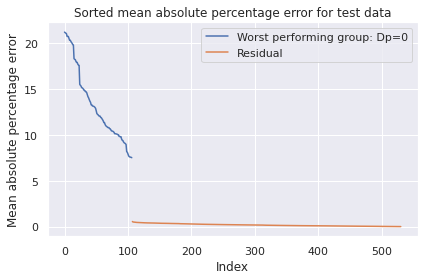

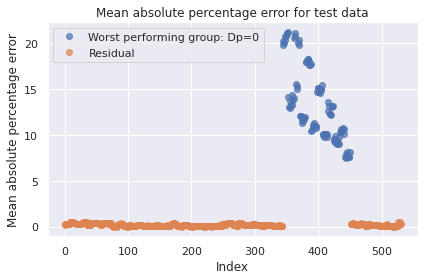

Metrics:<br>--training data:<br>----MAPE: 0.046140234949364305<br>----RMSE: 18.45506851818752<br>--test data:<br>----MAPE: 2.810303556680282<br>----RMSE: 936.2270936024785<br>----MAPE (w/o error): 0.17599611917189634<br>----RMSE (w/o error): 55.52722596089653<br>--combined data:<br>----MAPE: 0.5690368234207278<br>----RMSE: 407.5384776933218<br>----MAPE (w/o error): 0.06653241824949525<br>----RMSE (w/o error): 27.772151664758304<br>

<br>

Evaluate np_model_1:

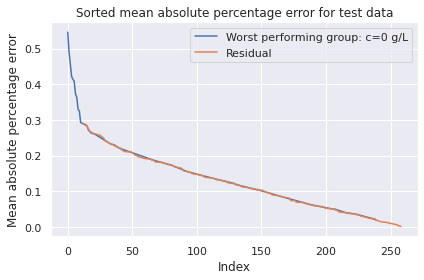

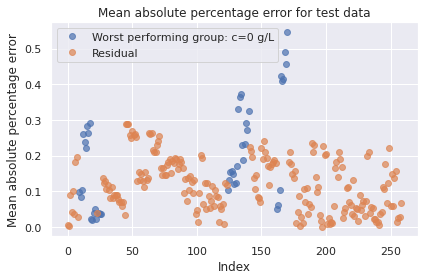

Metrics:<br>--training data:<br>----MAPE: 0.06134875465198188<br>----RMSE: 24.91373884810834<br>--test data:<br>----MAPE: 0.13327268590828104<br>----RMSE: 28.749340177189584<br>----MAPE (w/o error): 0.11917635181032694<br>----RMSE (w/o error): 28.938681554876695<br>--combined data:<br>----MAPE: 0.06798512736141596<br>----RMSE: 25.29201841008432<br>----MAPE (w/o error): 0.0658678432866427<br>----RMSE (w/o error): 25.251398089643075<br>

<br>

Evaluate np_model_2:

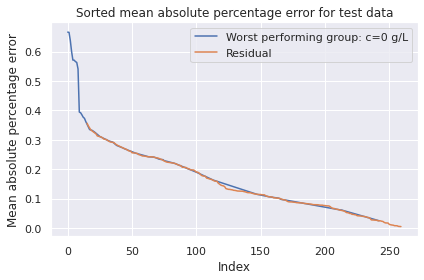

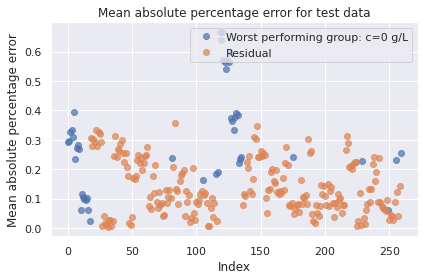

Metrics:<br>--training data:<br>----MAPE: 0.054157322646257736<br>----RMSE: 21.84681237121438<br>--test data:<br>----MAPE: 0.16733514405219008<br>----RMSE: 39.32268437270043<br>----MAPE (w/o error): 0.1383848066672936<br>----RMSE (w/o error): 37.6280144699244<br>--combined data:<br>----MAPE: 0.06464048387373988<br>----RMSE: 24.00622951968969<br>----MAPE (w/o error): 0.06071377053348536<br>----RMSE (w/o error): 23.459425003343096<br>

<br>

Evaluate np_model_3:

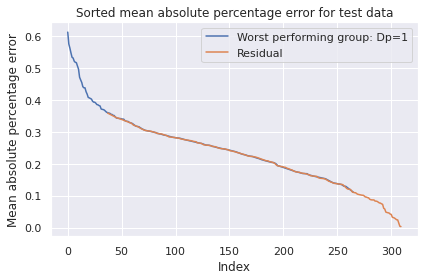

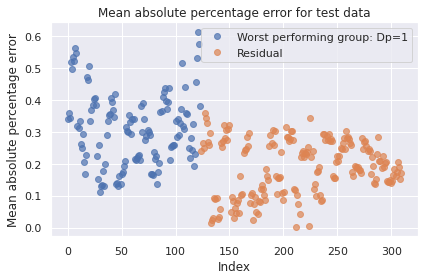

Metrics:<br>--training data:<br>----MAPE: 0.05408083061211714<br>----RMSE: 20.087497191816265<br>--test data:<br>----MAPE: 0.23788293065803182<br>----RMSE: 58.60377886680879<br>----MAPE (w/o error): 0.1898867889883579<br>----RMSE (w/o error): 44.521631192070984<br>--combined data:<br>----MAPE: 0.07437960190325842<br>----RMSE: 27.170464499785417<br>----MAPE (w/o error): 0.06349563055918415<br>----RMSE (w/o error): 22.64838432669919<br>

<br>

Evaluate np_model_4:

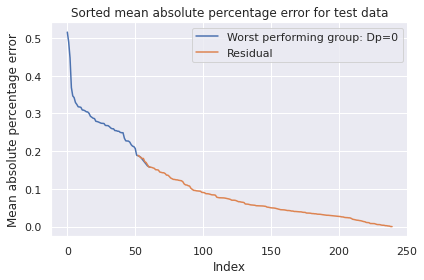

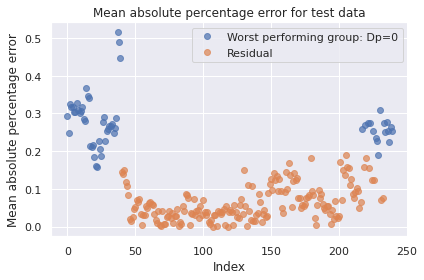

Metrics:<br>--training data:<br>----MAPE: 0.06766859936869236<br>----RMSE: 25.79735617117761<br>--test data:<br>----MAPE: 0.11288806947812947<br>----RMSE: 50.12836016807005<br>----MAPE (w/o error): 0.06290417328108655<br>----RMSE (w/o error): 16.88868690551623<br>--combined data:<br>----MAPE: 0.07153488822735461<br>----RMSE: 28.69586911413653<br>----MAPE (w/o error): 0.06734993182957226<br>----RMSE (w/o error): 25.29958346770586<br>

<br>

Evaluate np_model_5:

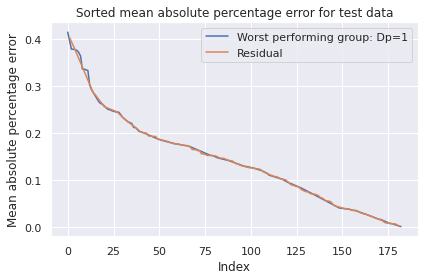

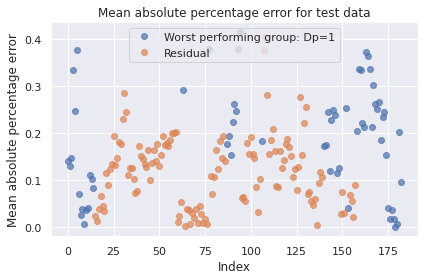

Metrics:<br>--training data:<br>----MAPE: 0.05348779110854386<br>----RMSE: 20.512828020785296<br>--test data:<br>----MAPE: 0.1428582690481444<br>----RMSE: 49.69794479654046<br>----MAPE (w/o error): 0.11988241260820036<br>----RMSE (w/o error): 35.343699781185165<br>--combined data:<br>----MAPE: 0.05931422411992501<br>----RMSE: 23.54498009272203<br>----MAPE (w/o error): 0.056414475699239096<br>----RMSE (w/o error): 21.384390340626712<br>

<br>

Evaluate np_model_6:

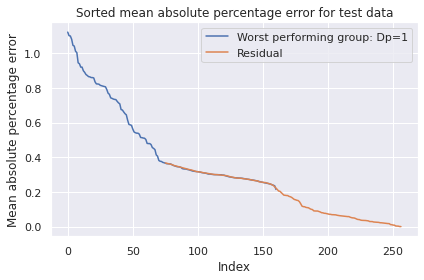

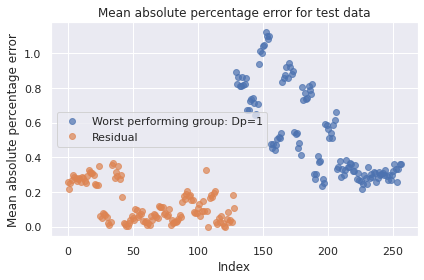

Metrics:<br>--training data:<br>----MAPE: 0.05376514037392872<br>----RMSE: 22.438987287734943<br>--test data:<br>----MAPE: 0.33462363735619244<br>----RMSE: 73.17097381920186<br>----MAPE (w/o error): 0.1316840458687121<br>----RMSE (w/o error): 41.493318248276154<br>--combined data:<br>----MAPE: 0.07947965185395785<br>----RMSE: 30.783160721204396<br>----MAPE (w/o error): 0.05751711454668984<br>----RMSE (w/o error): 23.710054110571644<br>

<br>

Evaluate np_model_7:

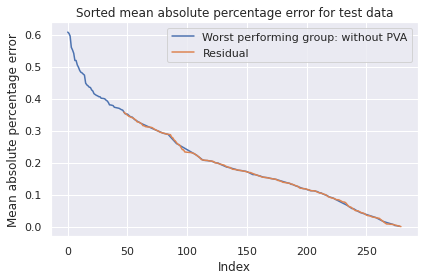

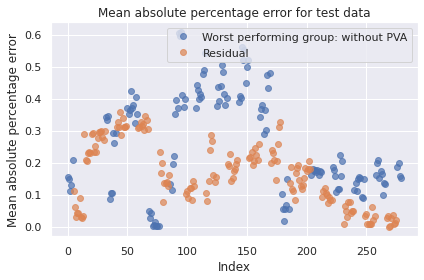

Metrics:<br>--training data:<br>----MAPE: 0.05815956724228309<br>----RMSE: 23.881685751994<br>--test data:<br>----MAPE: 0.20886189606684127<br>----RMSE: 44.17065208962158<br>----MAPE (w/o error): 0.1645500229978325<br>----RMSE (w/o error): 42.518880831796075<br>--combined data:<br>----MAPE: 0.07319221849660311<br>----RMSE: 26.609429840159663<br>----MAPE (w/o error): 0.06419590515749156<br>----RMSE (w/o error): 25.309066217770994<br>

<br>

Evaluate np_model_8:

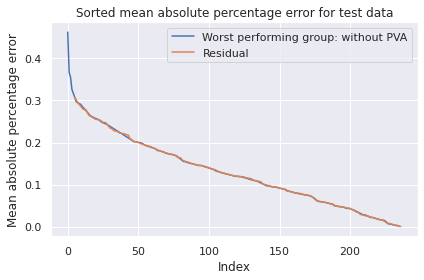

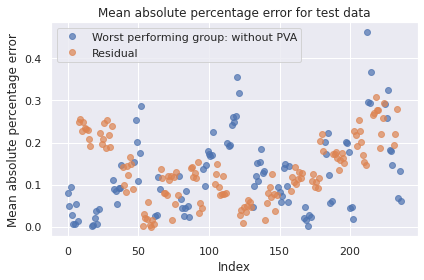

Metrics:<br>--training data:<br>----MAPE: 0.04937116492179503<br>----RMSE: 18.893948095868353<br>--test data:<br>----MAPE: 0.13152901777101933<br>----RMSE: 48.569254585935695<br>----MAPE (w/o error): 0.13523202223254666<br>----RMSE (w/o error): 52.5095398432797<br>--combined data:<br>----MAPE: 0.05630789848975589<br>----RMSE: 22.9349722473274<br>----MAPE (w/o error): 0.053565699771913174<br>----RMSE (w/o error): 21.777074490994682<br>

<br>

Evaluate np_model_9:

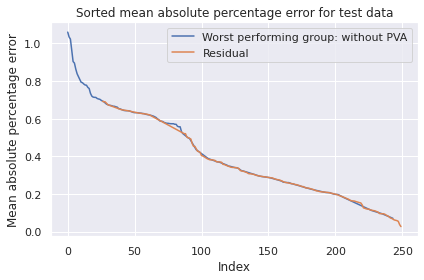

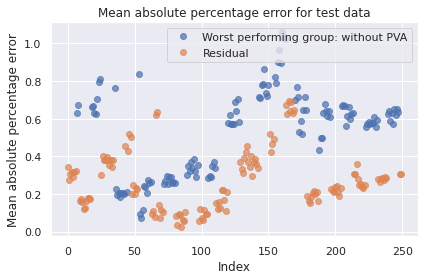

Metrics:<br>--training data:<br>----MAPE: 0.04749936377305033<br>----RMSE: 16.29361988844087<br>--test data:<br>----MAPE: 0.401554036950253<br>----RMSE: 85.65043567811041<br>----MAPE (w/o error): 0.274162552905228<br>----RMSE (w/o error): 78.667760651877<br>--combined data:<br>----MAPE: 0.07903255518534126<br>----RMSE: 29.919955454340567<br>----MAPE (w/o error): 0.058304908729817084<br>----RMSE (w/o error): 23.406221776387454<br>

<br>

Evaluate np_model_10:

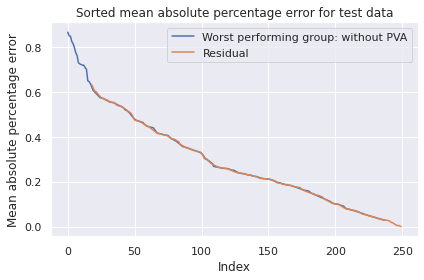

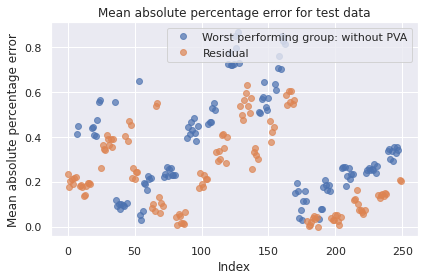

Metrics:<br>--training data:<br>----MAPE: 0.10331032882547049<br>----RMSE: 34.48422808594879<br>--test data:<br>----MAPE: 0.29768767066809465<br>----RMSE: 77.03428933458903<br>----MAPE (w/o error): 0.2420803867177978<br>----RMSE (w/o error): 78.47384810109578<br>--combined data:<br>----MAPE: 0.1206221690323305<br>----RMSE: 40.14694079825211<br>----MAPE (w/o error): 0.10992581017005815<br>----RMSE (w/o error): 37.7630056471327<br>

<br>

Evaluate np_model_11:

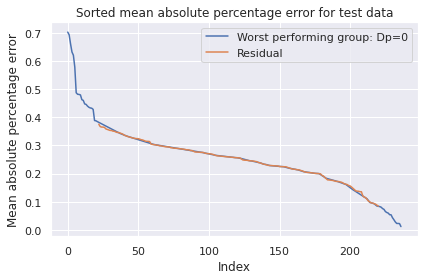

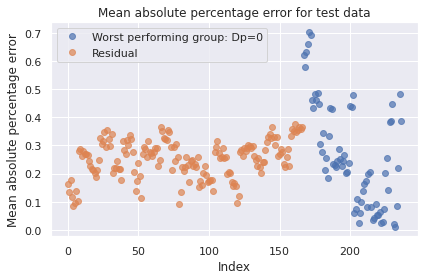

Metrics:<br>--training data:<br>----MAPE: 0.05800806009632727<br>----RMSE: 20.635627453881828<br>--test data:<br>----MAPE: 0.2567698173849615<br>----RMSE: 79.08807592815813<br>----MAPE (w/o error): 0.2529712333516655<br>----RMSE (w/o error): 79.6953379222025<br>--combined data:<br>----MAPE: 0.07478986860270642<br>----RMSE: 30.298348844514763<br>----MAPE (w/o error): 0.06990387665958685<br>----RMSE (w/o error): 28.06027080728444<br>

<br>

Evaluate np_model_12:

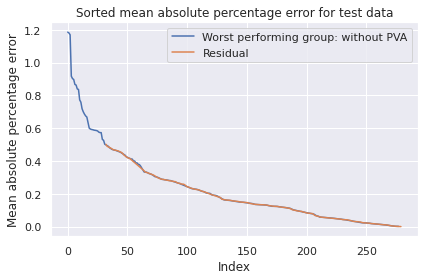

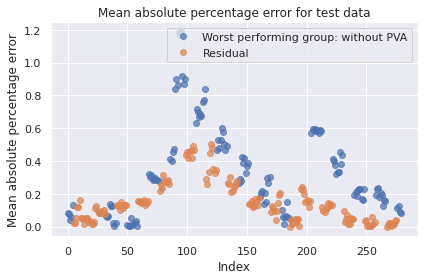

Metrics:<br>--training data:<br>----MAPE: 0.05749805507072053<br>----RMSE: 23.535618293713302<br>--test data:<br>----MAPE: 0.23515880804437847<br>----RMSE: 50.38787249512301<br>----MAPE (w/o error): 0.14529811459718844<br>----RMSE (w/o error): 38.41468887206681<br>--combined data:<br>----MAPE: 0.07521982594091084<br>----RMSE: 27.421370307234184<br>----MAPE (w/o error): 0.06247961873179672<br>----RMSE (w/o error): 24.62161525937285<br>

<br>

Evaluate np_model_13:

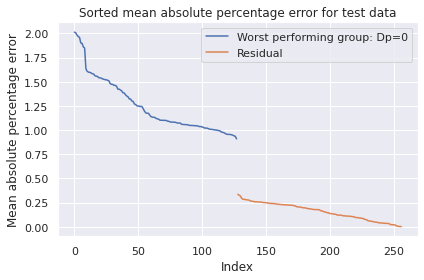

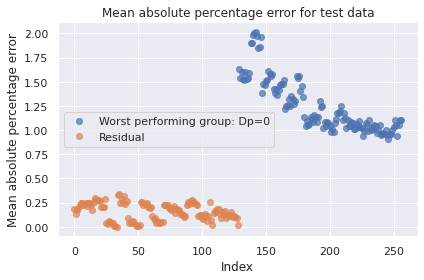

Metrics:<br>--training data:<br>----MAPE: 0.05543022864216529<br>----RMSE: 20.599389861327552<br>--test data:<br>----MAPE: 0.7029578058796456<br>----RMSE: 147.52400420616524<br>----MAPE (w/o error): 0.15854809738396522<br>----RMSE (w/o error): 42.50249440149768<br>--combined data:<br>----MAPE: 0.11471579592040983<br>----RMSE: 48.76541411060645<br>----MAPE (w/o error): 0.06039559074283426<br>----RMSE (w/o error): 22.15598020037877<br>

<br>

,path,name,training_MAPE,training_rmse,test_MAPE,test_rmse,combined_MAPE,combined_rmse,test_MAPE_without_worse,test_rmse_without_worse,...,fcn_model,featurizer,gcn_layer_sizes,gcn_output_dims,learning_rate,loss_function,metrics,pooling,smiles_column,task_names
0,pretrained/np_model_0,np_model_0,0.046140,18.455069,2.810304,936.227094,0.569037,407.538478,0.175996,55.527226,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
1,pretrained/np_model_1,np_model_1,0.061349,24.913739,0.133273,28.749340,0.067985,25.292018,0.119176,28.938682,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
2,pretrained/np_model_2,np_model_2,0.054157,21.846812,0.167335,39.322684,0.064640,24.006230,0.138385,37.628014,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
3,pretrained/np_model_3,np_model_3,0.054081,20.087497,0.237883,58.603779,0.074380,27.170464,0.189887,44.521631,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
4,pretrained/np_model_4,np_model_4,0.067669,25.797356,0.112888,50.128360,0.071535,28.695869,0.062904,16.888687,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
5,pretrained/np_model_5,np_model_5,0.053488,20.512828,0.142858,49.697945,0.059314,23.544980,0.119882,35.343700,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
6,pretrained/np_model_6,np_model_6,0.053765,22.438987,0.334624,73.170974,0.079480,30.783161,0.131684,41.493318,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
7,pretrained/np_model_7,np_model_7,0.058160,23.881686,0.208862,44.170652,0.073192,26.609430,0.164550,42.518881,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
8,pretrained/np_model_8,np_model_8,0.049371,18.893948,0.131529,48.569255,0.056308,22.934972,0.135232,52.509540,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]
9,pretrained/np_model_9,np_model_9,0.047499,16.293620,0.401554,85.650436,0.079033,29.919955,0.274163,78.667761,...,"{'layer': [{'args': [67, 32], 'module': 'Linea...","[atom_symbol_hcnopsclbr_other_one_hot, atom_de...","[None, None, None, None, None, None]",64,0.001,"{'kwargs': {}, 'name': 'RMAE'}","[MAPE, rmse]","[weight_sum, max]",circular_smiles_10,[z_average]


In [359]:
source_folder="pretrained"

eval_data=[]
for model_path in sorted([f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder,f))],
                         #reverse=True,
                         key=lambda f: int(f.rsplit("_",maxsplit=1)[1])
                         ):
    model_dir=os.path.join(source_folder,model_path)
    if os.path.isdir(model_dir):
        ev = evaluate(model_dir)
        eval_data.append(ev)

eval_df=pd.DataFrame(eval_data)
display(eval_df)

In [356]:
#model.save_last_prediction_tensor=True
#model.save_last_input_data=True

#test_df.loc[np.isnan(test_df["dp"]),"dp"]=400
#if "level_0" in test_df.columns:
#    test_df.drop("level_0",axis=1,inplace=True)




#mask = test_df["dp"]== test_df["dp"]-1
#n_mask = test_df["dp"] == (test_df[test_df["rel_error"] == test_df["rel_error"].max()]["dp"]).unique()[0]
#mask = n_mask

#n_mask = test_df["dp"] == (test_df[test_df["rel_error"] == test_df[~mask]["rel_error"].max()]["dp"]).unique()[0]
#mask = mask | n_mask 

#raise Exception("remove me")

#python main.py --train="__last" --model_path="pretrained/np_model_11"

In [357]:
eval_df.to_csv(os.path.join(source_folder,"evaluation_results.csv"),index=None)